## Analysis of historical data of IPC levels
For this analysis we use two sources of IPC levels, those produced by FewsNet (https://fews.net) and those producted by Global IPC (http://www.ipcinfo.org).   
FewsNet has produced these analyses since 2009. Global IPC is a more recent initiative where the timing and coverage of the analysis depends on the country. For Ethiopia currently (Oct 2020) two analyses have been done, one in 2019 and one in 2020. 

In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from datetime import timedelta
import matplotlib.dates as dates
from sklearn.metrics import accuracy_score
import geopandas as gpd
import warnings
warnings.filterwarnings('ignore')

In [3]:
country="somalia"

#### Load FewsNet data

In [4]:
#df_fadm1=pd.read_csv(f"Data/FewsNetCombined/{country}_admin1_fewsnet_combined_20090701_20200801.csv",index_col=0)
df_fadm1=pd.read_csv("../data/ethiopia_admin1_fewsnet_combined_20090701_20201001.csv",index_col=0)
df_fadm1.date=pd.to_datetime(df_fadm1.date)

In [5]:
#done now cause 2020-08 contains only predictions so bit confusing. But in future should be removed
df_fadm1=df_fadm1[df_fadm1.date<="2020-06"]

In [6]:
def add_columns(df):
    #Population not food-insecure
    df["CS_12"]=df["CS_1"]+df["CS_2"]
    #calculate percentage of population per status and level
    for status in ["CS","ML1","ML2"]:
        for i in range(1,6):
            c=f"{status}_{i}"
            df[f"perc_{c}"]=df[c]/df[f"pop_{status}"]*100
        df[f"{status}_3p"]=df[f"{status}_3"]+df[f"{status}_4"]+df[f"{status}_5"]
        df[f"perc_{status}_3p"]=df[f"{status}_3p"]/df[f"pop_{status}"]*100
        df[f'{status}_2-']=df[[f'{status}_{i}' for i in range(1,3)]].sum(axis=1)
        df[f'perc_{status}_2-']=df[f'{status}_2-']/df[f'pop_{status}']*100
    return df

In [7]:
df_fadm1=add_columns(df_fadm1)

In [8]:
#group to country
df_fnat=df_fadm1.groupby("date",as_index=False).sum()
#to make the plotting code work
df_fnat["ADM1_EN"]=country.capitalize()
df_fnat=add_columns(df_fnat)

##### Check for missing data

In [9]:
print("Number of date-admin1 combinations with no IPC CS data:", len(df_fadm1[df_fadm1.adjusted_population==0]))

Number of date-admin1 combinations with no IPC CS data: 0


In [10]:
print("Percentage of missing data:",len(df_fadm1[df_fadm1.adjusted_population==0])/len(df_fadm1)*100)

Percentage of missing data: 0.0


#### Load Global IPC data

In [12]:
#df_ipcg=pd.read_excel("Data/GlobalIPC/GlobalIPC_newcolumnnames.xlsx",header=11)
df_ipcg=pd.read_excel("../data/GlobalIPC_newcolumnnames.xlsx",header=11)

In [13]:
df_ipcg=df_ipcg[df_ipcg.date.notnull()]
df_ipcg["date"]=pd.to_datetime(df_ipcg["date"])

In [14]:
#Due to excel setting, the percentages are loaded as fractions so convert to percentages
perc_cols=[col for col in df_ipcg.columns if 'perc' in col]
df_ipcg[perc_cols]=df_ipcg[perc_cols]*100

In [15]:
#Population not food-insecure
for status in ["CS","ML1","ML2"]:
    df_ipcg[f"{status}_12"]=df_ipcg[f"{status}_1"]+df_ipcg[f"{status}_2"]
    df_ipcg[f'{status}_2-']=df_ipcg[[f'{status}_{i}' for i in range(1,3)]].sum(axis=1)
    df_ipcg[f'perc_{status}_2-']=df_ipcg[f'{status}_2-']/df_ipcg[f'pop_{status}']*100

In [16]:
df_gnat=df_ipcg[df_ipcg["Country"].str.contains('Ethiopia:')]
df_gnat["Country"]=country.capitalize()

In [17]:
df_gadm1=df_ipcg[~df_ipcg["Country"].str.contains('Ethiopia')]
df_gadm1=df_gadm1.drop("ADMIN1",axis=1)
#Country column contains the admin1 name
df_gadm1=df_gadm1.rename(columns={"Country":"ADMIN1"})

### Analysis of historical IPC values
To get a better understanding of the country's typical values and history, both on national and admin1 level

In [18]:
def plot_ipclevels(df,adm1c="ADM1_EN",pop_col="adjusted_population",status="CS",figsize=(30,30),width=75):
    color_map = {1:'#C9E1C5', 2:'#F2E65D', 3:'#DD8236', 4:'#BD3430', 5:'#551010', 99: '#CCCCCC'}
    
#     width = 75
    count = 1
    fig, ax = plt.subplots(figsize=figsize)
    if f"{status}_12" not in df.columns:
        df[f"{status}_12"]=df[f"{status}_1"]+df[f"{status}_2"]
    for region in df[adm1c].unique():
        ax = plt.subplot(6,2,count)
        df_c=df.copy()
        data = df_c.loc[df_c[adm1c]==region,:]

        p4 = plt.bar(data['date'], data[f'{status}_5'], width=width, color=color_map[5],label="IPC 5")
        p4 = plt.bar(data['date'], data[f'{status}_4'], width=width, color=color_map[4],label="IPC 4")
        p3 = plt.bar(data['date'], data[f'{status}_3'], width=width, color=color_map[3], bottom=(data[f'{status}_4']+data[f'{status}_5']).to_numpy(),label="IPC 3")
        p2 = plt.bar(data['date'], data[f'{status}_12'], width=width, color=color_map[1], bottom=(data[f'{status}_3']+data[f'{status}_4']+data[f'{status}_5']).to_numpy(),label="IPC 1 and 2")
        data["pop_miss"]=data[pop_col]-(data[f"pop_{status}"].replace(np.nan,0))
        p1 = plt.bar(data['date'], data['pop_miss'], width=width, color=color_map[99], bottom=(data[f"{status}_12"]+data[f'{status}_3']+data[f'{status}_4']+data[f'{status}_5']).to_numpy(),label="Missing data")

        plt.title(f"{region} {status}")
        ax.legend(bbox_to_anchor=(1.04, 1),frameon=False)

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_xlabel("Date")
        ax.set_ylabel("Population")
        
        ax.xaxis.set_minor_locator(dates.MonthLocator())
        ax.xaxis.set_minor_formatter(dates.DateFormatter('%b'))
        ax.xaxis.set_major_locator(dates.YearLocator())
        ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n%Y'))
        plt.tight_layout()
        plt.setp(ax.xaxis.get_minorticklabels(), rotation=90)
        ax.set_xticks(data.date.values,minor=True)
        ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        count+=1
    fig.tight_layout(pad=3.0)
    

#### FewsNet

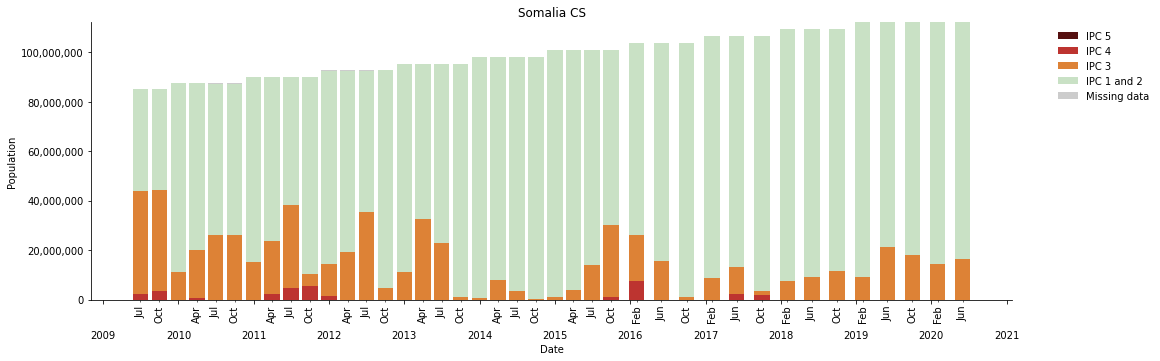

In [19]:
plot_ipclevels(df_fnat)

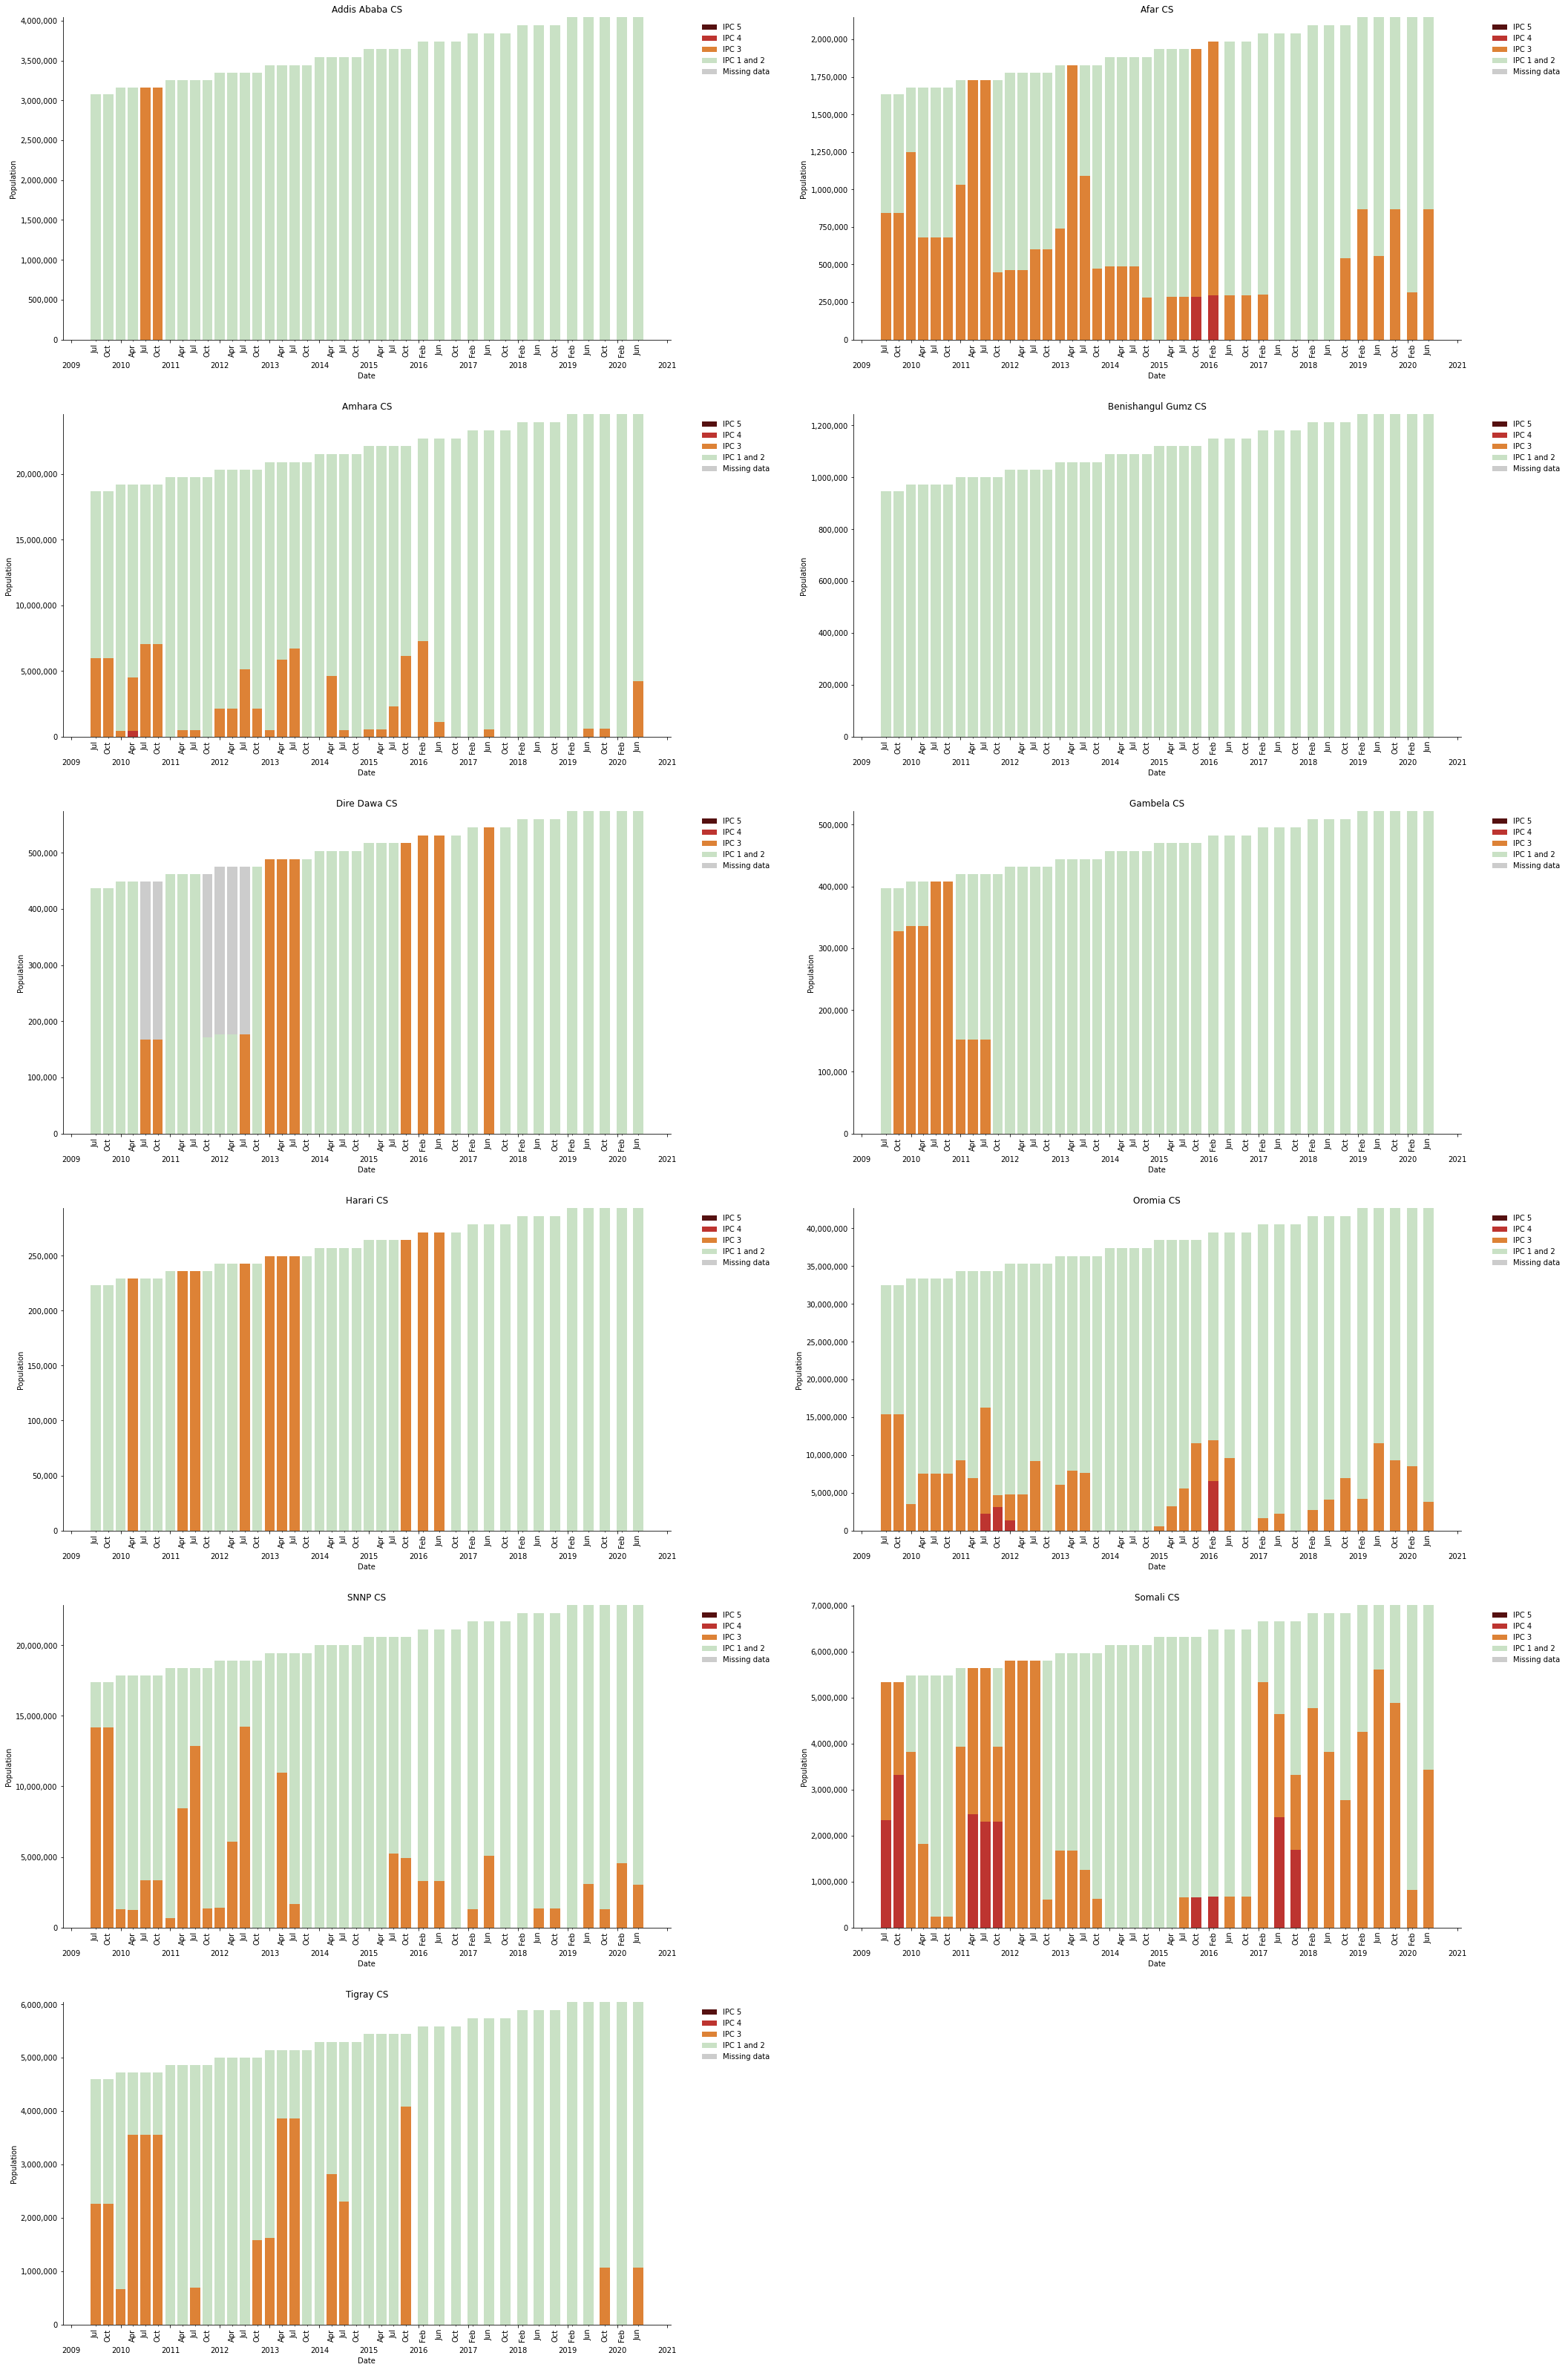

In [20]:
plot_ipclevels(df_fadm1,figsize=(30,45))

#### Global IPC

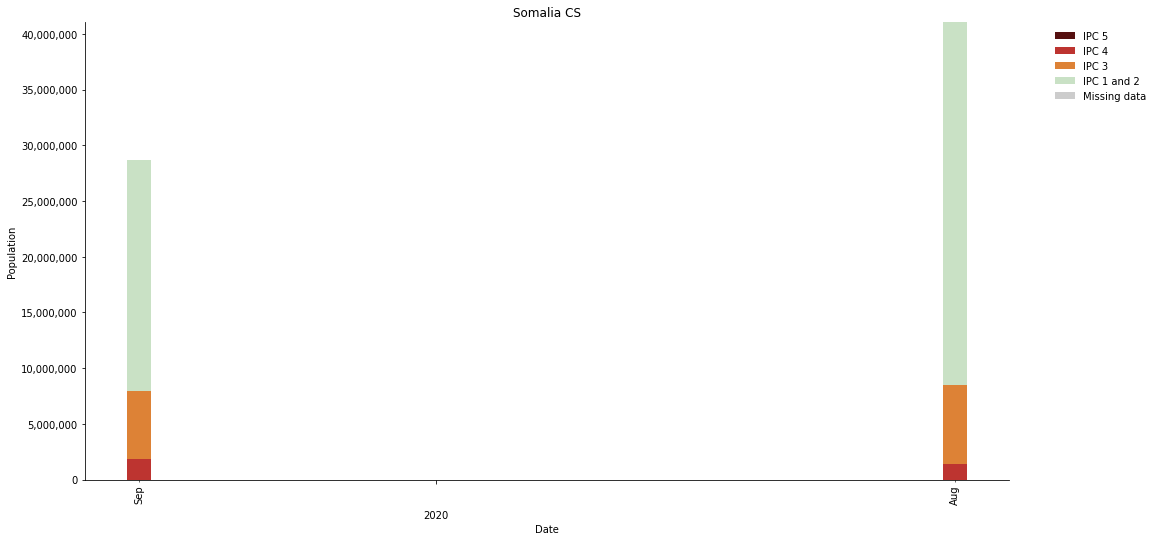

In [21]:
plot_ipclevels(df_gnat,adm1c="Country",pop_col="pop_CS",figsize=(30,45),width=10)

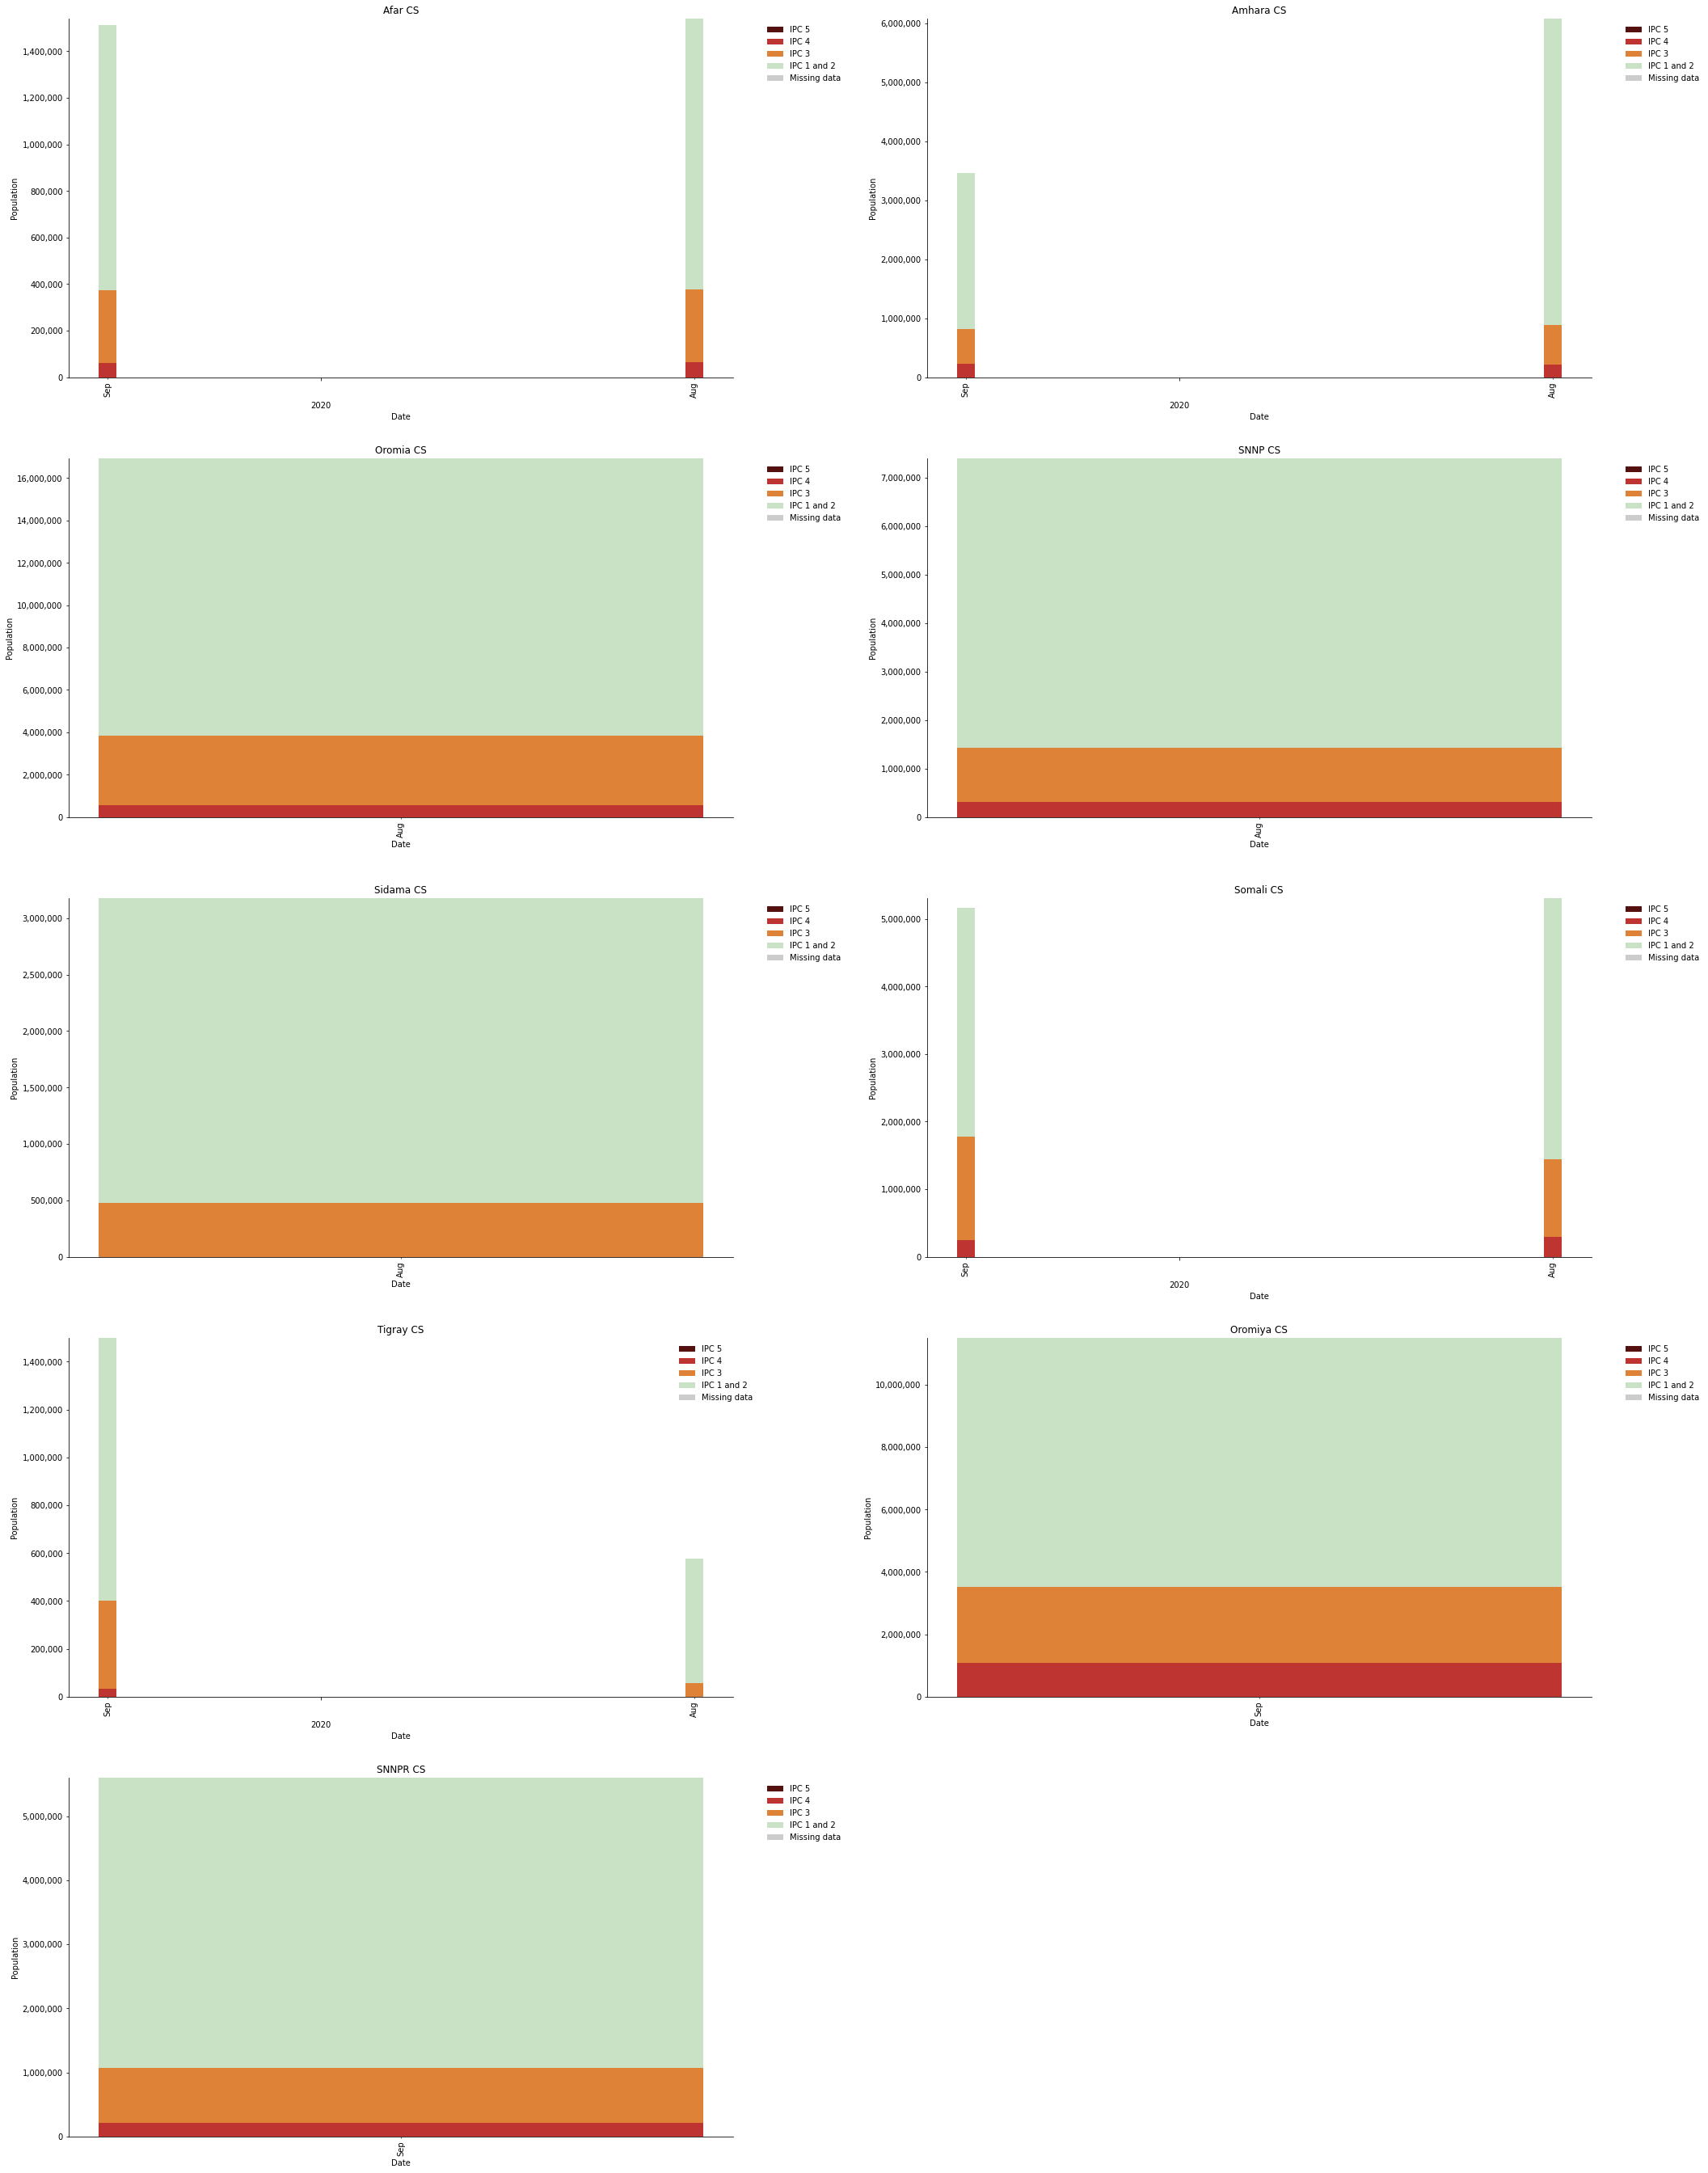

In [22]:
plot_ipclevels(df_gadm1,adm1c="ADMIN1",pop_col="pop_CS",figsize=(30,45),width=10)

In [25]:
#def plot_aff_dates(df_d,col,shape_path="Data/ET_Admin1_OCHA_2019/eth_admbnda_adm1_csa_bofed_20190827.shp",title=None):
def plot_aff_dates(df_d,col,shape_path="../data/ET_Admin1_OCHA_2019/eth_admbnda_adm1_csa_bofed_20190827.shp",title=None):
    """Plot a map with the values of col per admin1 for all dates included in df_d"""
    num_dates=len(df_d.date.unique())
    colp_num=2
    rows=num_dates // colp_num
    rows+=num_dates % colp_num
    position = range(1, num_dates + 1)

    gdf = gpd.read_file(shape_path)
    df_geo=gdf[["ADM1_EN","geometry"]].merge(df_d,on="ADM1_EN",how="left")
    
    colors = len(df_geo[col].unique())
    cmap = 'Blues'
    figsize = (16, 10)
    scheme = "natural_breaks"#'equalinterval'
    fig = plt.figure(1,figsize=(16,6*rows))
    
    for i,c in enumerate(df_d.date.unique()):
        ax = fig.add_subplot(rows,colp_num,position[i])
        df_date=df_geo[df_geo.date==c]
        if df_date[col].isnull().values.all():
            print(f"No not-NaN values for {c}")
        elif df_date[col].isnull().values.any():
            df_geo[df_geo.date==c].plot(col, ax=ax,cmap=cmap, figsize=figsize, k = colors,  legend=True,scheme=scheme,missing_kwds={"color": "lightgrey", "edgecolor": "red",
   "hatch": "///",
    "label": "Missing values"})
        else:
            df_geo[df_geo.date==c].plot(col, ax=ax,cmap=cmap, figsize=figsize, k = colors,  legend=True,scheme=scheme)
        gdf.boundary.plot(linewidth=0.2,ax=ax)

        ax.axis("off")
        
        plt.title(pd.DatetimeIndex([c])[0].to_period('M'))
        if not df_date[col].isnull().values.all():
            leg = ax.get_legend()

            for lbl in leg.get_texts():
                label_text = lbl.get_text()
                upper = label_text.split(",")[-1].rstrip(']')

                try:
                    new_text = f'{float(upper):,.2f}'
                except:
                    new_text=upper
                lbl.set_text(new_text)

    if title:
        fig.suptitle(title,fontsize=14)
    fig.tight_layout()#show()
    plt.show()

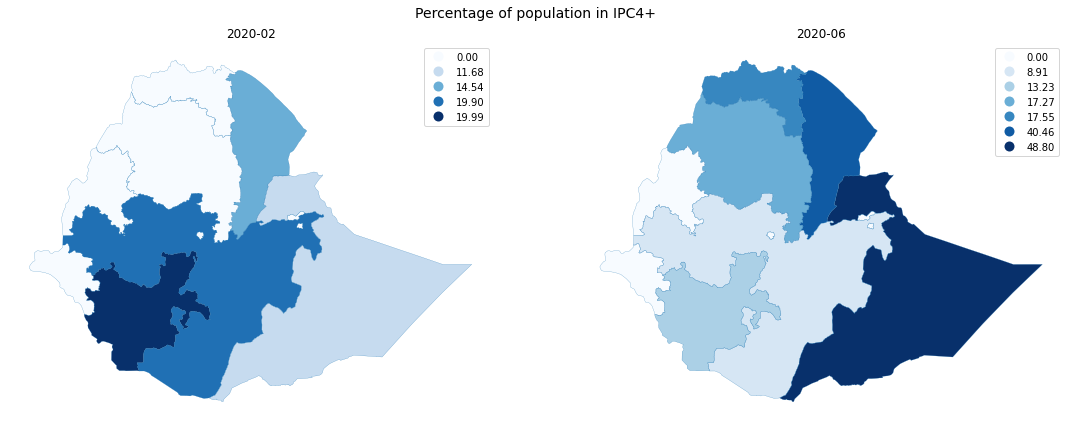

In [28]:
plot_aff_dates(df_fadm1[df_fadm1.date.dt.year==2020],"perc_CS_3p",title="Percentage of population in IPC4+")

### Compare Global IPC and FewsNet

In [29]:
df_fnat["Source"]="FewsNet"
df_gnat["Source"]="Global"

In [30]:
col_list=["Source","pop_Country","date","pop_CS","pop_ML1","pop_ML2"]+[f"CS_{i}" for i in range(1,6)]+[f"ML1_{i}" for i in range(1,6)]+[f"ML2_{i}" for i in range(1,6)]+[f"perc_CS_{i}" for i in range(1,6)]+[f"perc_ML1_{i}" for i in range(1,6)]+[f"perc_ML2_{i}" for i in range(1,6)]
df_fnat=df_fnat.rename(columns={"adjusted_population":"pop_Country"})
df_fnats=df_fnat[col_list]
df_gnats=df_gnat[col_list]

In [31]:
#manually select the closes dates of Global IPC and FewsNet..
list(df_gnats.date.dt.date.unique())

[datetime.date(2020, 8, 1), datetime.date(2019, 9, 1)]

In [32]:
df_fnats.date.dt.date.unique()

array([datetime.date(2009, 7, 1), datetime.date(2009, 10, 1),
       datetime.date(2010, 1, 1), datetime.date(2010, 4, 1),
       datetime.date(2010, 7, 1), datetime.date(2010, 10, 1),
       datetime.date(2011, 1, 1), datetime.date(2011, 4, 1),
       datetime.date(2011, 7, 1), datetime.date(2011, 10, 1),
       datetime.date(2012, 1, 1), datetime.date(2012, 4, 1),
       datetime.date(2012, 7, 1), datetime.date(2012, 10, 1),
       datetime.date(2013, 1, 1), datetime.date(2013, 4, 1),
       datetime.date(2013, 7, 1), datetime.date(2013, 10, 1),
       datetime.date(2014, 1, 1), datetime.date(2014, 4, 1),
       datetime.date(2014, 7, 1), datetime.date(2014, 10, 1),
       datetime.date(2015, 1, 1), datetime.date(2015, 4, 1),
       datetime.date(2015, 7, 1), datetime.date(2015, 10, 1),
       datetime.date(2016, 2, 1), datetime.date(2016, 6, 1),
       datetime.date(2016, 10, 1), datetime.date(2017, 2, 1),
       datetime.date(2017, 6, 1), datetime.date(2017, 10, 1),
       datetime

In [33]:
df_fnatsd=df_fnats[df_fnats.date.isin(["2019-10","2020-06"])]

In [34]:
df_comb=pd.concat([df_gnats,df_fnatsd])

In [35]:
df_comb

Source  pop_Country       date       pop_CS      pop_ML1      pop_ML2  \
0    Global  114964000.0 2020-08-01   41028219.0   41028219.0   41808767.0   
48   Global  112079000.0 2019-09-01   28727077.0   28727077.0   29224406.0   
37  FewsNet  112078686.0 2019-10-01  112078686.0  112078686.0  112078686.0   
39  FewsNet  112078686.0 2020-06-01  112078686.0  112078686.0  112078686.0   

          CS_1        CS_2        CS_3       CS_4  ...  perc_ML1_1  \
0   19514840.0  13007693.0   7064142.0  1441541.0  ...   53.000000   
48  10726519.0  10033578.0   6110416.0  1856564.0  ...   40.000000   
37  63852796.0  30296279.0  17929611.0        0.0  ...   70.846156   
39  59435618.0  36210928.0  16432140.0        0.0  ...   54.907189   

    perc_ML1_2  perc_ML1_3  perc_ML1_4  perc_ML1_5  perc_ML2_1  perc_ML2_2  \
0    30.000000   14.000000         2.0         0.0   43.000000   31.000000   
48   37.000000   19.000000         5.0         0.0   37.000000   35.000000   
37   19.758665    9.395179         0.0         0.0   56.541574   24.953041   
39   26.019815   19.072996         0.0         0.0   69.815417   16.265929   

    perc_ML2_3  perc_ML2_4  perc_ML2_5  
0    21.000000         5.0         0.0  
48   22.000000         6.0         0.0  
37   18.505385         0.0         0.0  
39   13.918654         0.0         0.0  

[4 rows x 36 columns]

In [36]:
df_comb=add_columns(df_comb)

In [37]:
df_combm=df_comb.melt(id_vars=["Source","date"],value_name="percentage",value_vars=['perc_CS_2-','perc_CS_3',"perc_CS_4","perc_CS_5"])

In [38]:
df_combm["year"]=df_combm.date.dt.year

In [39]:
fig=px.bar(df_combm,x="variable",y="percentage",color="Source",facet_row="year",barmode="group",height=600,width=800) #,facet_row="year"
fig.update_xaxes(ticktext=["IPC2-","IPC3","IPC4","IPC5"],tickvals=["perc_CS_2-","perc_CS_3","perc_CS_4","perc_CS_5"])
fig.show()

In [40]:
g_adm1=df_gadm1.ADMIN1.unique()

In [41]:
df_fadm1s=df_fadm1[df_fadm1.date.isin(["2019-10","2020-06"])]

In [36]:
df_fadm1s=df_fadm1s.rename(columns={"ADM1_EN":"ADMIN1"})
df_fadm1s=df_fadm1s[df_fadm1s.ADMIN1.isin(g_adm1)]

df_fadm1s["Source"]="FewsNet"
df_gadm1["Source"]="Global"

In [37]:
df_adm1c=pd.concat([df_gadm1,df_fadm1s])


In [38]:
df_adm1cm=df_adm1c.melt(id_vars=["Source","date","ADMIN1"],value_name="percentage",value_vars=['perc_CS_2-','perc_CS_3',"perc_CS_4","perc_CS_5"])
df_adm1cm["year"]=df_adm1cm.date.dt.year

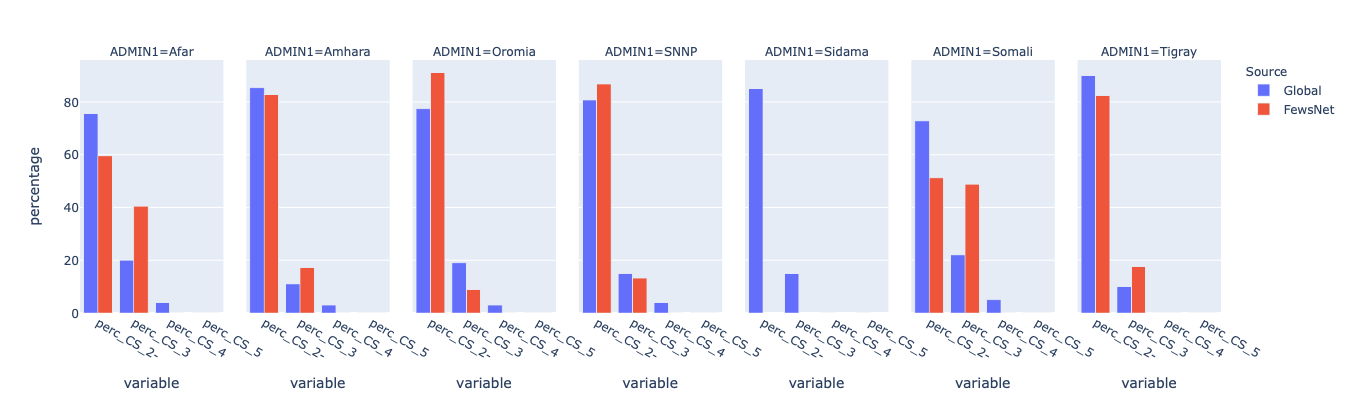

In [39]:
#Sidama is a new admin1 region in Ethiopia that wasn't included in the 06-2020 FewsNet analysis
px.bar(df_adm1cm[df_adm1cm.year==2020],x="variable",y="percentage",color="Source",facet_col="ADMIN1",barmode="group",height=400,width=1300) #,facet_row="year"

### Actual value (CS) versus forecasted values (ML1 and ML2)
Only being done for FewsNet.  
For global IPC we have two timestamps of data till today, where none of the dates overlap. Thus, we cannot do an analysis on accuracy

In [40]:
#set the forecasted ML1 and ML2 values for the connected date
#now assumed ML1 is always forecasted for the next date in the df. This can be too simplified, in 'old stuff' is a start to do this more correctly
#(optimally the dates for which forecasts were produced would already be included in the df from the start)
shift_cols_ML1=["date"] + [f"ML1_{i}" for i in range(1,6)]+[f"perc_ML1_{i}" for i in range(1,6)]+["ML1_3p","perc_ML1_3p"]
shift_cols_ML2=["date"] + [f"ML2_{i}" for i in range(1,6)]+[f"perc_ML2_{i}" for i in range(1,6)]+["ML2_3p","perc_ML2_3p"]
df_fnat[[f"{c}_next" for c in shift_cols_ML1]]=df_fnat[shift_cols_ML1].shift(1)
df_fnat[[f"{c}_next2" for c in shift_cols_ML2]]=df_fnat[shift_cols_ML2].shift(2)
df_fadm1[[f"{c}_next" for c in shift_cols_ML1]]=df_fadm1.groupby("ADM1_EN")[shift_cols_ML1].shift(1)
df_fadm1[[f"{c}_next2" for c in shift_cols_ML2]]=df_fadm1.groupby("ADM1_EN")[shift_cols_ML2].shift(2)

#set to nan if difference in dates is larger than 130/250, i.e. forecast was not for next date in df
#dont include "date" in shift_cols_ML1
for i in shift_cols_ML1[1:]:
    df_fnat[i] = df_fnat[i].where((df_fnat.date - df_fnat.date_next) <= timedelta(130), np.nan)
    df_fadm1[i] = df_fadm1[i].where((df_fadm1.date - df_fadm1.date_next) <= timedelta(130), np.nan)
for i in shift_cols_ML2[1:]:
    df_fnat[i] = df_fnat[i].where((df_fnat.date - df_fnat.date_next2) <= timedelta(250), np.nan)
    df_fadm1[i] = df_fadm1[i].where((df_fadm1.date - df_fadm1.date_next2) <= timedelta(250), np.nan)

In [41]:
#read admin2 level data
df_adm2=pd.read_csv("Data/FewsNetCombined/ethiopia_admin2_fewsnet_combined_20090701_20200801.csv",index_col=0)

In [42]:
#add forecasted values to date they were forecasted for
for a in df_adm2.ADM1_EN.unique():
    for b in df_adm2.ADM2_EN.unique():
        df_adm2.loc[(df_adm2.ADM1_EN==a) & (df_adm2.ADM2_EN==b),f"ML1_next"]=df_adm2.loc[(df_adm2.ADM1_EN==a) & (df_adm2.ADM2_EN==b),"ML1"].shift(1).to_numpy()
        df_adm2.loc[(df_adm2.ADM1_EN==a) & (df_adm2.ADM2_EN==b),f"ML2_next2"]=df_adm2.loc[(df_adm2.ADM1_EN==a) & (df_adm2.ADM2_EN==b),"ML2"].shift(2).to_numpy()
        df_adm2.loc[(df_adm2.ADM1_EN==a) & (df_adm2.ADM2_EN==b),f"date_next"]=df_adm2.loc[(df_adm2.ADM1_EN==a) & (df_adm2.ADM2_EN==b),"date"].shift(1).to_numpy()
        df_adm2.loc[(df_adm2.ADM1_EN==a) & (df_adm2.ADM2_EN==b),f"date_next2"]=df_adm2.loc[(df_adm2.ADM1_EN==a) & (df_adm2.ADM2_EN==b),"date"].shift(2).to_numpy()

In [43]:
df_adm2["CS_3p"]=np.where(df_adm2.CS>=3,1,0)
df_adm2["ML1_next_3p"]=np.where(df_adm2.ML1_next>=3,1,0)
df_adm2["ML2_next2_3p"]=np.where(df_adm2.ML2_next2>=3,1,0)

In [44]:
df_adm2s=df_adm2.dropna()

In [45]:
print("Accuracy of ML1 forecasts:",accuracy_score(df_adm2s.CS,df_adm2s.ML1_next))

Accuracy of ML1 forecasts: 0.7858757062146893


In [46]:
print("Accuracy of ML2 forecasts:",accuracy_score(df_adm2s.CS,df_adm2s.ML2_next2))

Accuracy of ML2 forecasts: 0.7245762711864406


In [47]:
print("Accuracy of ML1 forecasts for IPC3+:",accuracy_score(df_adm2s.CS_3p,df_adm2s.ML1_next_3p))

Accuracy of ML1 forecasts for IPC3+: 0.8807909604519774


In [48]:
print("Accuracy of ML2 forecasts for IPC3+:",accuracy_score(df_adm2s.CS_3p,df_adm2s.ML2_next2_3p))

Accuracy of ML2 forecasts for IPC3+: 0.842090395480226


In [49]:
df_adm2["CSminML1"]=df_adm2["CS"]-df_adm2["ML1_next"]

In [50]:
#can be seen that about equally divided whether ML1 is over or underpredicting CS
df_adm2.value_counts("CSminML1").sort_index()

CSminML1
-2.0      14
-1.0     367
 0.0    2874
 1.0     363
 2.0      15
dtype: int64

In [51]:
df_adm2["CSminML2"]=df_adm2["CS"]-df_adm2["ML2_next2"]

In [52]:
df_adm2.value_counts("CSminML2").sort_index()

CSminML2
-3.0       2
-2.0      46
-1.0     458
 0.0    2565
 1.0     428
 2.0      41
dtype: int64

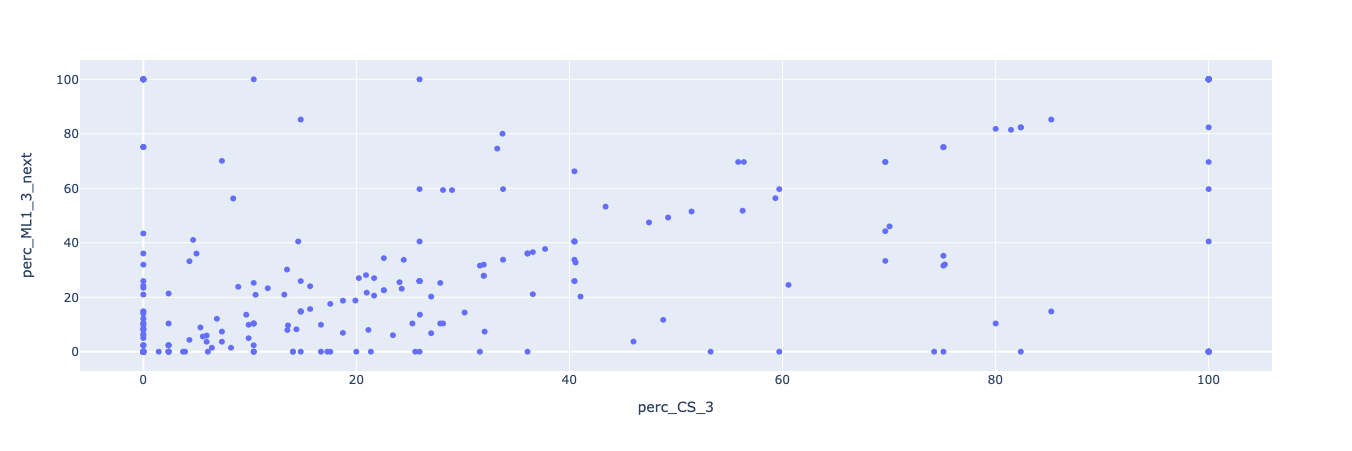

In [53]:
px.scatter(df_fadm1,x="perc_CS_3",y="perc_ML1_3_next",width=500,height=450)

In [54]:
def plot_preds(df,adm1c="ADM1_EN"):
    color_map = {1:'#C9E1C5', 2:'#F2E65D', 3:'#DD8236', 4:'#BD3430', 5:'#551010', 99: '#CCCCCC'}
    
    width = 75
    count = 1
    fig, ax = plt.subplots(figsize=(20,30))
  
    for region in df[adm1c].unique():
        ax = plt.subplot(6,2,count)
        data = df.loc[df[adm1c]==region]
        plt.plot(data['date'], data['perc_CS_3p'], label='CS',
                         alpha=0.75, color='#E6B655', linestyle='-', linewidth=4)
        plt.plot(data['date'], data['perc_ML1_3p_next'], color='#388c50',
                         label='ML1', linestyle=':', linewidth=2)
        plt.plot(data['date'], data['perc_ML2_3p_next2'], color='#c24e2d',
                         label='ML2', linestyle='-.', linewidth=2)
        plt.title(f"{region} IPC 3+")
        ax.legend(bbox_to_anchor=(1.04, 1),frameon=False,title="Legend")

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_xlabel("Date")
        ax.set_ylabel("Percentage of population")
        ax.set_xticks(data.date.values,minor=True)
        ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        count+=1
    fig.tight_layout(pad=3.0)

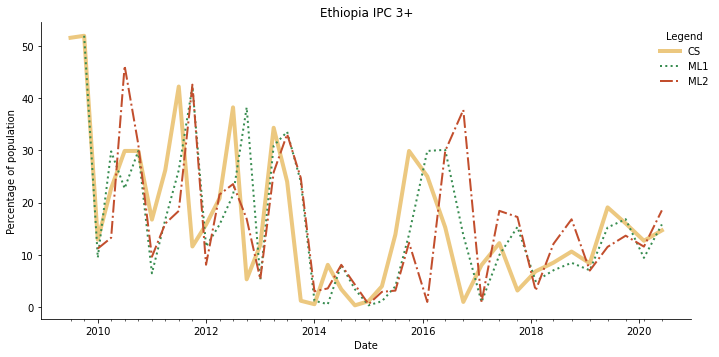

In [55]:
plot_preds(df_fnat)

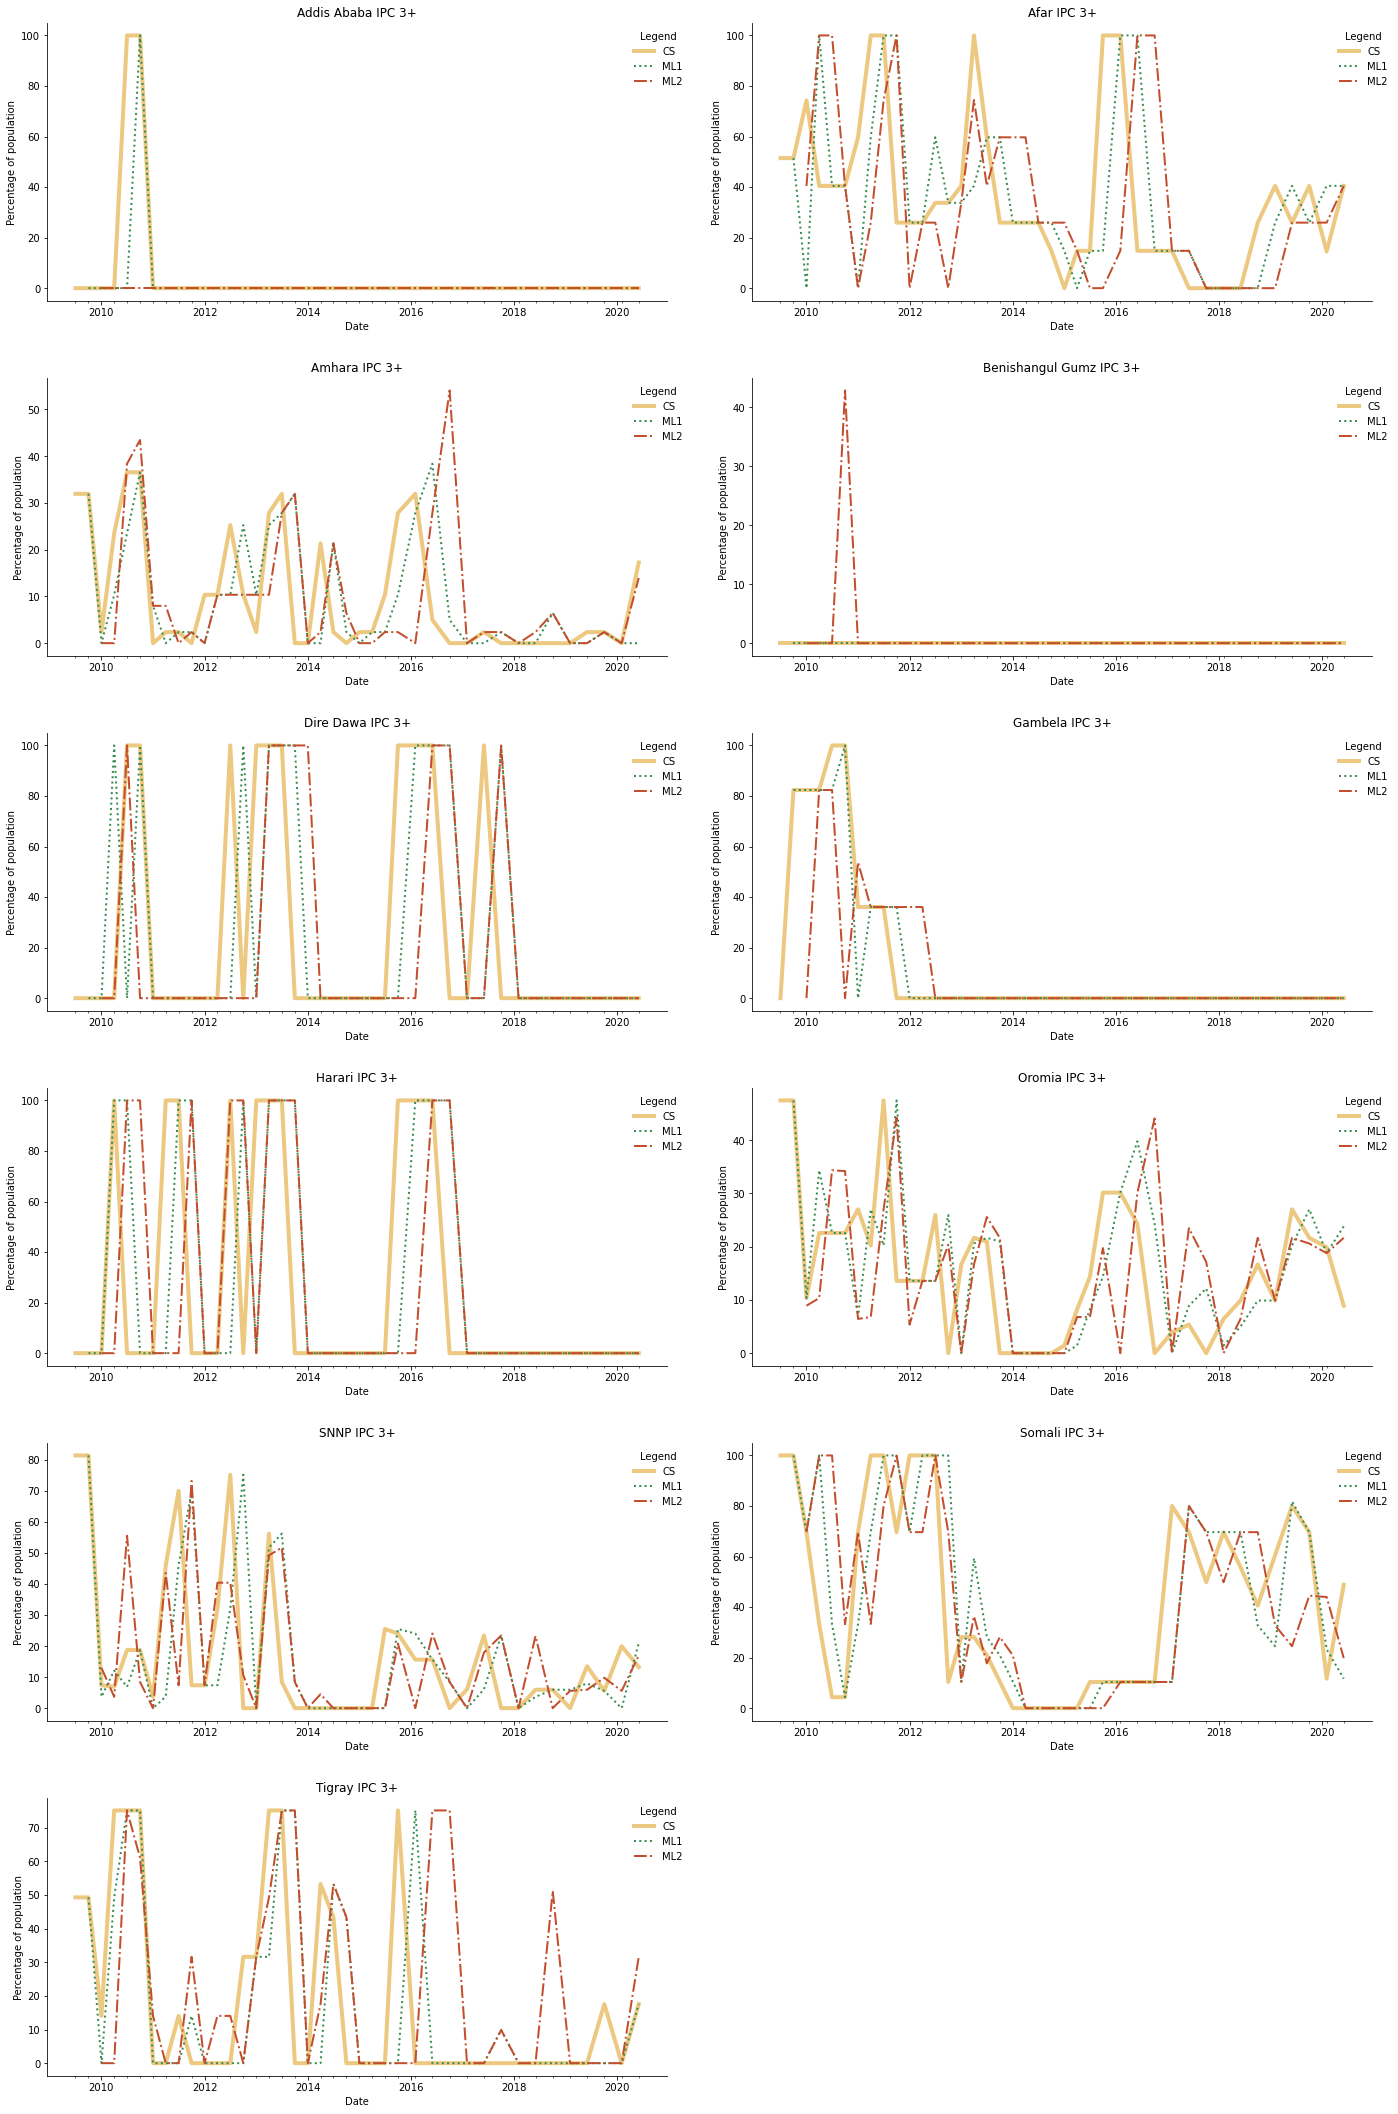

In [56]:
plot_preds(df_fadm1)

In [57]:
def plot_preds_nodelay(df,adm1c="ADM1_EN"):
    color_map = {1:'#C9E1C5', 2:'#F2E65D', 3:'#DD8236', 4:'#BD3430', 5:'#551010', 99: '#CCCCCC'}
    
    width = 75
    count = 1
    fig, ax = plt.subplots(figsize=(20,30))
  
    for region in df[adm1c].unique():
        ax = plt.subplot(6,2,count)
        data = df.loc[df[adm1c]==region]
        plt.plot(data['date'], data['perc_CS_3p'], label='CS',
                         alpha=0.75, color='#E6B655', linestyle='-', linewidth=4)
        plt.plot(data['date'], data['perc_ML1_3p'], color='#388c50',
                         label='ML1', linestyle=':', linewidth=2)
        plt.plot(data['date'], data['perc_ML2_3p'], color='#c24e2d',
                         label='ML2', linestyle='-.', linewidth=2)
        plt.title(f"NO DELAY! {region} IPC 3+")
        ax.legend(bbox_to_anchor=(1.04, 1),frameon=False,title="Legend")

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        ax.set_xticks(data.date.values,minor=True)
        ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        count+=1
    fig.tight_layout(pad=3.0)
    

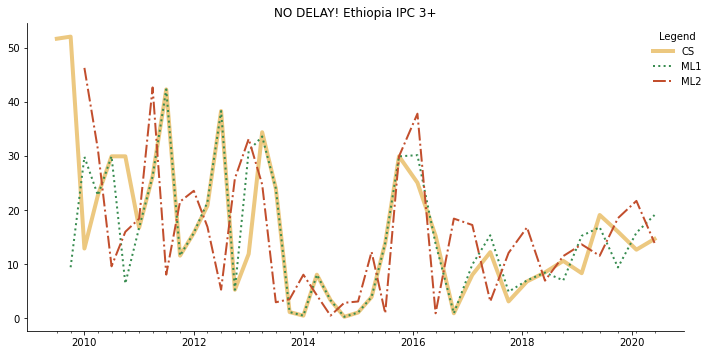

In [58]:
plot_preds_nodelay(df_fnat)

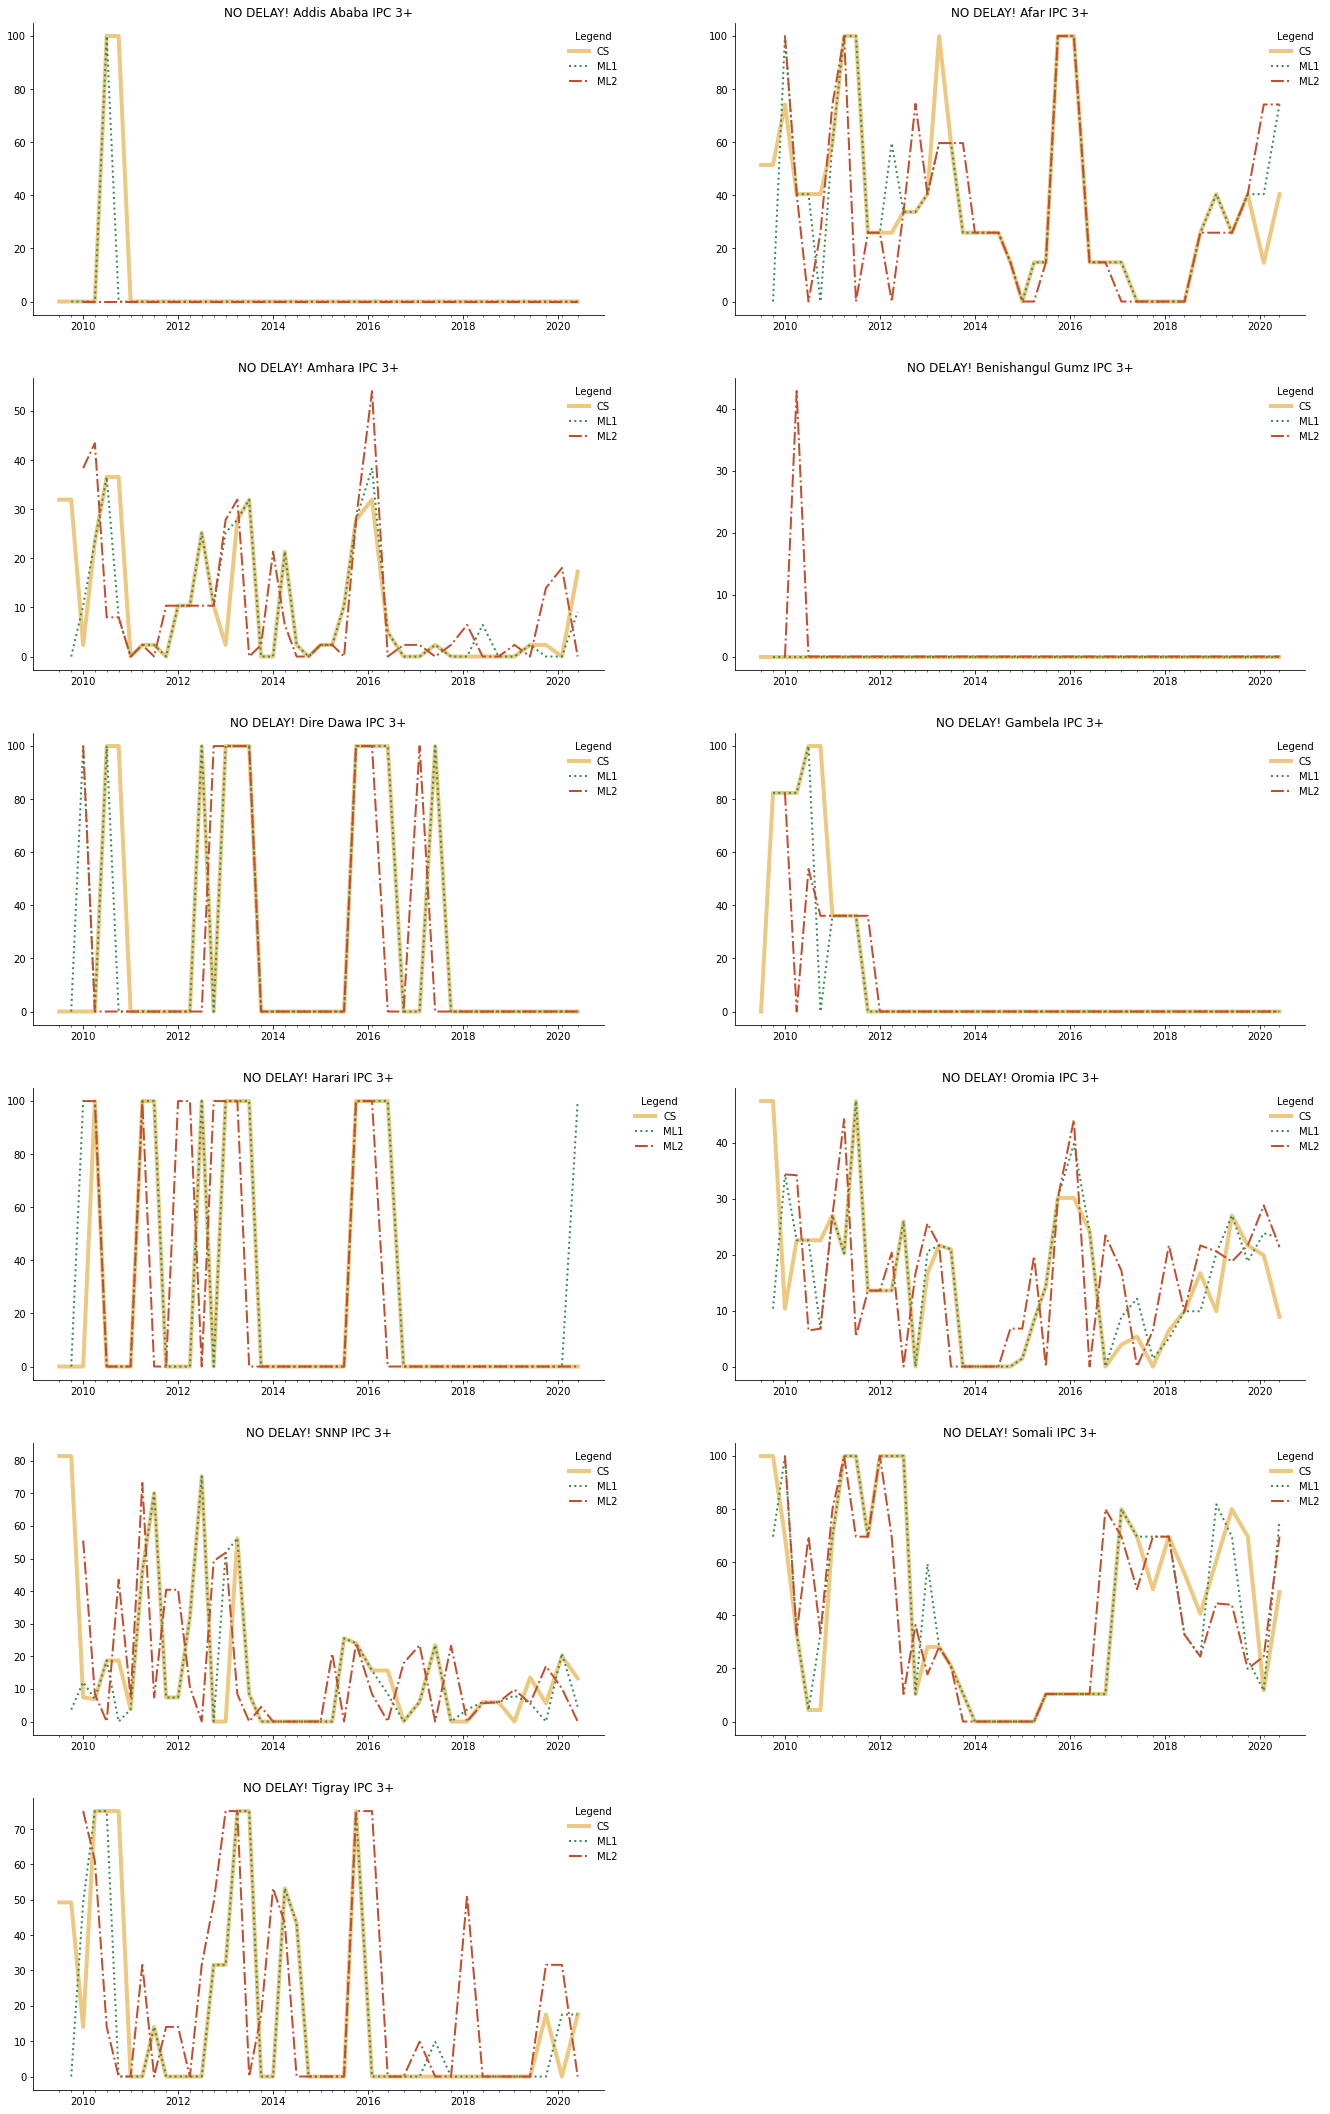

In [59]:
plot_preds_nodelay(df_fadm1)

In [60]:
df_fnat[f"ML1_i"]=(df_fnat["perc_ML1_3p"]-df_fnat["perc_CS_3p"])
df_fnat[f"ML2_i"]=(df_fnat["perc_ML2_3p"]-df_fnat["perc_CS_3p"])

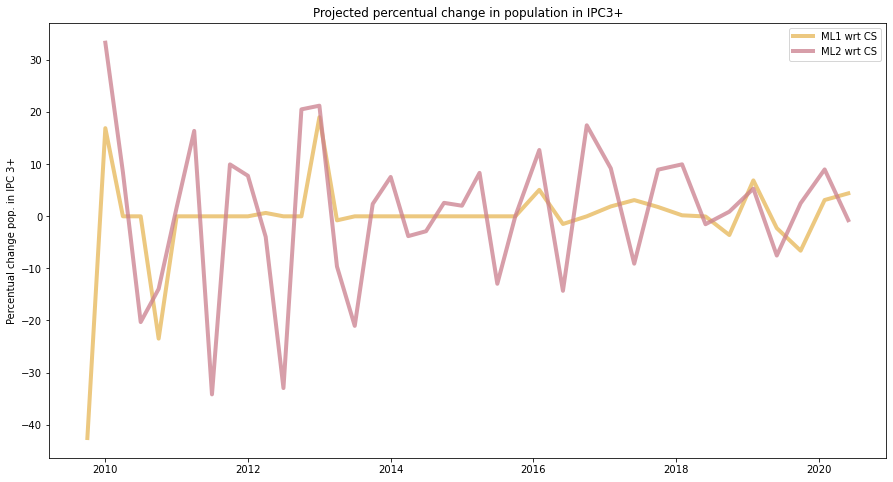

In [61]:
plt.figure(figsize=(15, 8))
plt.ticklabel_format(style='plain', axis='y')
plt.plot(df_fnat['date'], df_fnat['ML1_i'], label='ML1 wrt CS',
                 alpha=0.75, color='#E6B655', linestyle='-', linewidth=4)
plt.plot(df_fnat['date'], df_fnat['ML2_i'], label='ML2 wrt CS',
                 alpha=0.75, color='#CA7E8D', linestyle='-', linewidth=4)
plt.ylabel("Percentual change pop. in IPC 3+")
plt.title("Projected percentual change in population in IPC3+")
plt.legend()